# DSCI-6650 Assignment 2

## Preliminaries

In [1]:
from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from enum import StrEnum
from itertools import product
from typing import TypeAlias

import numpy as np
import numpy.typing as npt
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import root, OptimizeResult


### State Space

The state space of the gridworld can be represented by the set

$$
\mathcal{S} := [0, 4] \times [0, 4] = \{(i, j) \,|\, i \in [0, 4] \wedge \, j \in [0, 4]\},
$$

where $[a, b] \subset \mathbb{N}$, $a < b$, is just the set $\{a, a + 1, \ldots, b - 1, b\}$. Here, the top-most row is enumerated as row 0, with the row index increasing as we move down; and the left-most column is enumerated as column 0, with the column index increasing as we move right.

In this representation, each state is identified by the ordered pair $(i, j)$ of its row and column index.


The following simple immutable data class is used to implement the concept of a state in this world:


In [2]:
@dataclass(frozen=True)
class State:
    row: int
    col: int


Next, we define constants that specify the size of the grid. These will be used throughout the following.


In [3]:
NUM_ROWS: int = 5
NUM_COLS: int = 5

MIN_ROW: int = 0
MAX_ROW: int = 4

MIN_COL: int = 0
MAX_COL: int =  4


Finally, we implement the state space as a simple list of states and store that in global scope. This will be referenced throughout the rest of the code below.

We also define a convenience function that maps a row and column index to a specific state, and another convenience function that maps a state to its index in the list of states.


In [4]:
STATES: list[State] = [State(row, col) for row, col in product(range(NUM_ROWS), range(NUM_COLS))]


def get_state(row: int, col: int) -> int:
    for state in STATES:
        if state.row == row and state.col == col:
            return state
    raise ValueError(f"State ({row}, {col}) not found")


def get_state_index(state: State) -> int:
    return STATES.index(state)


### Action Space

We will denote the four possible actions by $\text{up}$, $\text{down}$, $\text{left}$, and $\text{right}$. Each state $s \in \mathcal{S}$ has the same action space, namely
$$
\mathcal{A}(s) = \mathcal{A} := \{\text{up}, \text{down}, \text{left}, \text{right}\}.
$$

We deliberately leave out a rigorous definition of the actions here, opting instead for a more intuitive, informal approach.


In [5]:
class Action(StrEnum):
    UP = "up"
    DOWN = "down"
    LEFT = "left"
    RIGHT = "right"


We define convenience functions for mapping an action to its index in the list of actions generated from the enum, and for mapping an index to its associated action:


In [6]:
def get_action_index(action: Action) -> int:
    return list(Action).index(action)


def get_action(index: int) -> Action:
    return list(Action)[index]


Finally, we define a convenience function for determining the best action from a given state, based on the action values for that state. Ties are broken randomly, according to a uniform distribution.


In [7]:
def get_best_action(state: State, action_values: npt.NDArray[np.float64], rng: np.random.Generator) -> Action:
    action_values_for_state: npt.NDArray[np.float64] = action_values[get_state_index(state), :]
    max_action_value: np.float64 = np.max(action_values_for_state)
    # Break ties randomly
    candidate_action_indices: npt.NDArray[np.int64] = np.flatnonzero(action_values_for_state == max_action_value)
    best_action_index: int = rng.choice([index for index in candidate_action_indices])
    
    return get_action(best_action_index)


### Policies

The concept of a policy is, mathematically, a conditional probability distribution over the action space, conditional on the current state. The notation, $\pi(a | s)$, while not standard probability theory notation, reflects this.

The following class implements this concept, providing a means to either get the probability distribution across actions for any given state, or to select an action given a state according to the probability distribution. Instances of this class will be used for both purposes in what follows.


In [8]:
class Policy:
    
    def __init__(
        self,
        probability_distribution_map: dict[State, dict[Action, float]],
        rng: np.random.Generator
    ) -> None:
        self._validate_probability_distribution_map(probability_distribution_map)
        self.probability_distribution_map: dict[State, dict[Action, float]] = probability_distribution_map
        self.rng: np.random.Generator = rng

    def __eq__(self, other: Policy) -> bool:
        return self.probability_distribution_map == other.probability_distribution_map

    @classmethod
    def _validate_probability_distribution_map(cls, probability_distribution_map: dict[State, dict[Action, float]]) -> None:
        for state in STATES:
            if state not in probability_distribution_map:
                raise KeyError(f"State {state} not in probability distribution map: {probability_distribution_map}")
        for _, probability_distribution in probability_distribution_map.items():
            cls._validate_probability_distribution(probability_distribution)
            
    @classmethod
    def _validate_probability_distribution(cls, probability_distribution: dict[Action, float]) -> None:
        for action in Action:
            if action not in probability_distribution:
                raise KeyError(f"Action {str(action)} not in probability distribution: {probability_distribution}")
        if not np.isclose(sum(probability_distribution.values()), 1.0):
            raise ValueError(f"Invalid probability distribution: {probability_distribution}")

    def update(self, state: State, probability_distribution: dict[Action, float]) -> None:
        self._validate_probability_distribution(probability_distribution)
        if state not in STATES:
            raise ValueError(f"Invalid state: {state}")
        self.probability_distribution_map[state] = probability_distribution
            
    def get_action(self, state: State) -> Action:
        probability_distribution: dict[Action, float] = self.probability_distribution_map[state]
        actions: list[Action] = list(probability_distribution.keys())
        probabilities: list[float] = [probability_distribution[action] for action in actions]
        return self.rng.choice(actions, p=probabilities)
    
    def get_probability(self, state: State, action) -> float:
        return self.probability_distribution_map[state][action]
    

### Visualizations

Next, we define a convenience function for plotting the state values as a heat map:


In [9]:
def plot_state_value_heat_map(state_value_vector: npt.NDArray[np.float64]) -> None:
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        state_value_vector.reshape((NUM_ROWS, NUM_COLS)),
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar=True,
        square=True,
        linewidths=.5
    )
    plt.title("State Values")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


We also define a function for plotting the policy along with the state value heat map. Arrows are overlaid on top of the heat map whose lengths indicate the relative probability of the each of the actions in each state.


In [10]:
def plot_state_value_heat_map_with_policy(
    state_value_vector: npt.NDArray[np.float64],
    policy: Policy,
    ignored_states: list[State] | None = None
) -> None:
    # Plot state values as a heat map
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        state_value_vector.reshape((NUM_ROWS, NUM_COLS)),
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        cbar=True,
        square=True,
        linewidths=.5
    )
    plt.title("State Values with Policy")
    plt.xlabel("Column")
    plt.ylabel("Row")

    # Represent actions as arrows
    action_vectors: list[tuple[float, float]] = {
        Action.UP: (-0.25, 0),
        Action.DOWN: (0.25, 0),
        Action.LEFT: (0, -0.25),
        Action.RIGHT: (0, 0.25)
    }

    # Overlay arrows for the policy over the heat map
    for state in STATES:
        if ignored_states is not None and state in ignored_states:
            continue
        for action in Action:
            probability: float = policy.get_probability(state, action)
            if np.isclose(probability, 0.0):
                continue
            dy, dx = action_vectors[action]
            plt.arrow(
                state.col + 0.5,
                state.row + 0.5,
                dx * probability,
                dy * probability,
                head_width=0.1,
                head_length=0.1,
                fc='k',
                ec='k',
                alpha=0.75
            )
    
    plt.show()


### Dynamics

Finally, we define a constant for the discount factor $\gamma$, which maintains a constant value of $0.95$ throughout what follows:


In [11]:
DISCOUNT_FACTOR: float = 0.95


We also define a convergence threshold $\Delta$, which is used to determine when the iterative algorithms implemented below have converged:


In [12]:
CONVERGENCE_THRESHOLD: float = 1e-6


## Part 1: No Terminal States

In order to evaluate the Bellman equation for the state-value function $v_{\pi}(s) := \mathbb{E}_{\pi}[G_{t + 1} | S_t = s]$, written

$$
v_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a | s) \sum_{s' \in \mathcal{S}, r \in \mathcal{R}} p(s', r | s, a)
                   [r + \gamma v_{\pi}(s')],
$$

we need to define three missing pieces: the reward space $\mathcal{R}$ from which the reward signal is drawn, the agent's decision-making logic via a policy $\pi(a | s)$, and the environment's Markovian dynamics via the dynamics function $p(s', r | s, a)$.

In the present case, the reward space is the set

$$
\mathcal{R} := \{-0.5, 0, 2.5, 5\}.
$$

We will leave the policy to either be specified in the subproblems below, or as something to be determined.

Finally, we define the environment's Markovian dynamics. For convenience, we introduce some notation for the four special states:

\begin{align*}
  \text{blue} :=&\, (0, 1), \\
 \text{green} :=&\, (0, 4), \\
   \text{red} :=&\, (3, 2), \,\text{and} \\
\text{yellow} :=&\, (4, 4).
\end{align*}


We also define constants that we will use later when implementing the solution algorithms:

In [13]:
BLUE: State = get_state(0, 1)
GREEN: State = get_state(0, 4)
RED: State = get_state(3, 2)
YELLOW: State = get_state(4, 4)


The dynamics function $p(s', r | s, a)$ can then be defined via the following table:

| $s$             | $a$            | $s'$            | $r$    | $p$   |
|:---------------:|:--------------:|:---------------:|:------:|:-----:|
| $\text{blue}$   | $\text{up}$    | $\text{red}$    | $5$    | $1$   |
| $\text{blue}$   | $\text{down}$  | $\text{red}$    | $5$    | $1$   |
| $\text{blue}$   | $\text{left}$  | $\text{red}$    | $5$    | $1$   |
| $\text{blue}$   | $\text{right}$ | $\text{red}$    | $5$    | $1$   |
| $\text{green}$  | $\text{up}$    | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{down}$  | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{left}$  | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{right}$ | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{up}$    | $\text{yellow}$ | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{down}$  | $\text{yellow}$ | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{left}$  | $\text{yellow}$ | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{right}$ | $\text{yellow}$ | $2.5$  | $0.5$ |
| $(0, j)$        | $\text{up}$    | $(0, j)$        | $-0.5$ | $1$   |
| $(4, j)$        | $\text{down}$  | $(4, j)$        | $-0.5$ | $1$   |
| $(i, 0)$        | $\text{left}$  | $(i, 0)$        | $-0.5$ | $1$   |
| $(i, 4)$        | $\text{right}$ | $(i, 4)$        | $-0.5$ | $1$   |
| $(i, j)$        | $\text{up}$    | $(i - 1, j)$    | $0$    | $1$   |
| $(i, j)$        | $\text{down}$  | $(i + 1, j)$    | $0$    | $1$   |
| $(i, j)$        | $\text{left}$  | $(i, j - 1)$    | $0$    | $1$   |
| $(i, j)$        | $\text{right}$ | $(i, j + 1)$    | $0$    | $1$   |

There is some redundancy here since, for example, $s = \text{blue}$ is a special case of $s = (0, j)$ where $j = 1$, so we establish an order of precedence where higher rows override lower rows.

It should also be noted that any choices of $(s', r, s, a)$ not listed have $p(s', r | s, a) = 0$, and can be safely ignored.


We define an implementation of this dynamics table as follows:


In [14]:
DynamicsTable: TypeAlias = list[tuple[State, Action, State, float, float]]


def get_standard_transition(state: State, action: Action) -> State:
    match action:
        case Action.UP:
            return get_state(state.row - 1, state.col)
        case Action.DOWN:
            return get_state(state.row + 1, state.col)
        case Action.LEFT:
            return get_state(state.row, state.col - 1)
        case Action.RIGHT:
            return get_state(state.row, state.col + 1)


def get_dynamics_table(standard_transition_reward: float) -> DynamicsTable:
    table: DynamicsTable = [
        *[(BLUE, action, RED, 5.0, 1.0) for action in list(Action)],
        *[(GREEN, action, RED, 2.5, 0.5) for action in list(Action)],
        *[(GREEN, action, YELLOW, 2.5, 0.5) for action in list(Action)]
    ]

    for col in range(NUM_COLS):
        state: State = get_state(MIN_ROW, col)
        if any(record[0] == state and record[1] == Action.UP for record in table):
            continue
        table.append((state, Action.UP, state, -0.5, 1.0))
    
    for col in range(NUM_COLS):
        state: State = get_state(MAX_ROW, col)
        if any(record[0] == state and record[1] == Action.DOWN for record in table):
            continue
        table.append((state, Action.DOWN, state, -0.5, 1.0))

    for row in range(NUM_ROWS):
        state: State = get_state(row, MIN_COL)
        if any(record[0] == state and record[1] == Action.LEFT for record in table):
            continue
        table.append((state, Action.LEFT, state, -0.1, 1.0))

    for row in range(NUM_ROWS):
        state: State = get_state(row, MAX_COL)
        if any(record[0] == state and record[1] == Action.RIGHT for record in table):
            continue
        table.append((state, Action.RIGHT, state, -0.1, 1.0))

    for row in range(NUM_ROWS):
        for col in range(NUM_COLS):
            state: State = get_state(row, col)
            for action in list(Action):
                if any(record[0] == state and record[1] == action for record in table):
                    continue
                table.append((state, action, get_standard_transition(state, action), standard_transition_reward, 1.0))
    
    return table


To avoid recomputing the table when it is needed, we compute it once and store the result in a constant for reuse:


In [15]:
DYNAMICS_TABLE: DynamicsTable = get_dynamics_table(0.0)


### 1.1.1: Solving the Bellman Equations Explicitly

Here, the agent's policy is defined as follows: for any given state $s \in \mathcal{S}$, the agent just chooses randomly among the four options with uniform probability:

$$
\forall s \in \mathcal{S}: \forall a \in \mathcal{A}: \pi(a | s) := \frac{1}{|\mathcal{A}|} = \frac{1}{4}.
$$

Returning to the Bellman equations for the state-value function, 

$$
v_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a | s) \sum_{s' \in \mathcal{S}, r \in \mathcal{R}} p(s', r | s, a)
                   [r + \gamma v_{\pi}(s')]
           = \frac{1}{4} \sum_{a, s', r} p(s', r | s, a) [r + \gamma v_{\pi}(s')],
$$

we first rewrite it as follows:

$$
v_{\pi}(s) = r_{\pi}(s) + \gamma \sum_{s'}P_{\pi}(s, s') v_{\pi}(s'),
$$

where we have introduced two new functions

$$
r_{\pi}(s) := \frac{1}{4} \sum_{a, s', r} p(s', r | s, a) r,
$$

which is just $\mathbb{E}[R_{t + 1} | S_t = s, \pi]$, and

$$
P_{\pi}(s, s') := \frac{1}{4} \sum_{a, r} p(s', r | s, a),
$$

which gives the probability of transitioning from state $s \in \mathcal{S}$ to state $s' \in \mathcal{S}$ under policy $\pi$.

Enumerating the states $s_0 = (0, 0)$, $s_1 = (1, 0)$, $\ldots$, $s_{24} = (4, 4)$, we can define vectors

$$
\mathbf{v}_{\pi} = \begin{bmatrix}
v_{\pi}(s_0) \\
v_{\pi}(s_1) \\
\vdots \\
v_{\pi}(s_{24})
\end{bmatrix}

\quad \text{and} \quad

\mathbf{r}_{\pi} = \begin{bmatrix}
r_{\pi}(s_0) \\
r_{\pi}(s_1) \\
\vdots \\
r_{\pi}(s_{24}) \\
\end{bmatrix},
$$

along with a matrix

$$
\mathbf{P}_{\pi} = \begin{bmatrix}
P_{\pi}(s_0, s_0) & P_{\pi}(s_0, s_1) & \cdots & P_{\pi}(s_0, s_{24}) \\
P_{\pi}(s_1, s_0) & P_{\pi}(s_1, s_1) & \cdots & P_{\pi}(s_1, s_{24}) \\
\vdots            & \vdots            & \ddots & \vdots \\
P_{\pi}(s_{24}, s_0) & P_{\pi}(s_{24}, s_1) & \cdots & P_{\pi}(s_{24}, s_{24}) \\
\end{bmatrix},
$$

which we can use to write the Bellman equations in matrix form as

$$
\mathbf{v}_{\pi} = \mathbf{r}_{\pi} + \gamma \mathbf{P}_{\pi} \mathbf{v}_{\pi}.
$$

Rearranging this gives

$$
(\mathbf{I} - \gamma \mathbf{P}_{\pi}) \mathbf{v}_{\pi} = \mathbf{r}_{\pi},
$$

which formulates the problem in a form that lends itself to straightforward implementation.


As a first step in explicitly solving the state value Bellman equations, we define two utility functions which take the table that defines the dynamics function $p(s', r | s, a)$ as input and give back the transition matrix $\mathbf{P}_{\pi}$ and the expected reward vector $\mathbf{r}_{\pi}$:

In [16]:
def get_transition_matrix(dynamics_table: DynamicsTable) -> npt.NDArray[np.float64]:
    matrix: npt.NDArray[np.float64] = np.zeros((len(STATES), len(STATES)), dtype=np.float64)

    for row, state in enumerate(STATES):
        for col, next_state in enumerate(STATES):
            records: DynamicsTable = [
                record for record in dynamics_table if record[0] == state and record[2] == next_state
            ]
            matrix[row, col] = 0.25 * sum(record[4] for record in records)

    return matrix


def get_expected_reward_vector(dynamics_table: DynamicsTable) -> npt.NDArray[np.float64]:
    vector: npt.NDArray[np.float64] = np.zeros(len(STATES), dtype=np.float64)

    for index, state in enumerate(STATES):
        records: DynamicsTable = [
            record for record in dynamics_table if record[0] == state
        ]
        vector[index] = 0.25 * sum(record[4] * record[3] for record in records)

    return vector


Next, we define a function, which, admittedly, is just a wrapper around the linear solver `np.linalg.solve`, that we will use to compute the state-value vector (i.e., function) using the above implementation:


In [17]:
def solve_bellman_equations(
    transition_matrix: npt.NDArray[np.float64],
    expected_reward_vector: npt.NDArray[np.float64],
    discount_factor: float
) -> npt.NDArray[np.float64]:
    return np.linalg.solve(
        np.eye(len(STATES)) - discount_factor * transition_matrix,
        expected_reward_vector
    )


Finally, we use the code above to solve the Bellman equations for the given policy $\pi$:


In [18]:
state_value_vector_exact: npt.NDArray[np.float64] = solve_bellman_equations(
    get_transition_matrix(DYNAMICS_TABLE),
    get_expected_reward_vector(DYNAMICS_TABLE),
    DISCOUNT_FACTOR
)


We use the above convenience function to visualize the state values as a heat map:


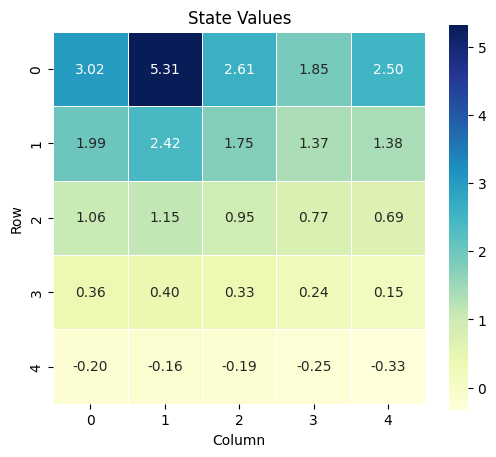

In [19]:
plot_state_value_heat_map(state_value_vector_exact)


As expected, the blue state has the highest value. Per the specification, taking any action from this state results in a reward of $5$, the largest possible reward the environment can supply.

The left and right neighbours of the blue state rank second and third, respectively. This, too, seems expected, since there's a relatively high probability that the blue state will be reached in a small number of steps.

The green state ranks fourth. This makes sense since the environment guarantees a reward of $2.5$ on any action from this state, which is the only other positive reward aside from acting from the blue state that the agent can receive.

As distance from the blue and green states increases, the state-value decreases, becoming negative in the bottom row. This makes sense since: 1) it seems likely that the agent will end up attempting to leave the grid multiple times before making its way to the blue or green states and receiving a positive reward; and 2) if the blue or green states are reached, it's likely to take a relatively large number of steps before that happens, so that the reward received upon finally reaching them is largely discounted.


### 1.1.2: Solving the Bellman Equations Using Iterative Policy Evaluation

Instead of solving the system of Bellman equations exactly for our uniform policy $\pi$, an alternative method for determining the state-value function $v_{\pi}$ is to start from an initial guess for $v_{\pi}$, which we denote $v_0$, and iteratively approach $v_{\pi}$ using the Bellman equations as an update rule. Using this approach, for each $k \in \{1, 2, \ldots, K\}$, where $K$ is some unknown constant at which we decide the sequence $(v_0, v_1, \ldots, v_{K + 1})$ has converged, we use the following update rule:

\begin{align*}
v_{k + 1}(s) :=&\, \mathbb{E}_{\pi}[R_{t + 1} + \gamma v_k(S_{t + 1}) | S_t = s] \\
              =&\, \sum_a \pi(a | s) \sum_{s', r} p(s', r | s, a) [r + \gamma v_k(s')] \\
              =&\, \frac{1}{4} \sum_{a, s', r} p(s', r | s, a) [r + \gamma v_k(s')] \\
              =&\, r_{\pi}(s) + \gamma \sum_{s'}P_{\pi}(s, s') v_k(s').
\end{align*}

Similar to what we did above, we can write this in vector form as

$$
\mathbf{v}_{k + 1} = \mathbf{r}_{\pi} + \gamma \mathbf{P}_{\pi} v_k,
$$

where $\mathbf{r}_{\pi}$ is the expected reward vector and $\mathbf{P}_{\pi}$ is the transition matrix, as defined above.


The following implements this iterative procedure, considering the sequence converged when $\|v_{k + 1} - v_k\|_{\infty} < \theta$ for some convergence threshold $\theta \in \mathbb{R}$:


In [20]:
def do_iterative_policy_evaluation(
    initial_state_value_vector: npt.NDArray[np.float64],
    transition_matrix: npt.NDArray[np.float64],
    expected_reward_vector: npt.NDArray[np.float64],
    discount_factor: float,
    convergence_threshold: float
) -> npt.NDArray[np.float64]:
    state_value_vector_iter: npt.NDArray[np.float64] = initial_state_value_vector.copy()
    state_value_vector_temp: npt.NDArray[np.float64] = state_value_vector_iter.copy()

    while True:
        state_value_vector_iter = expected_reward_vector \
            + discount_factor * transition_matrix @ state_value_vector_temp
        if np.max(np.abs(state_value_vector_iter - state_value_vector_temp)) < convergence_threshold:
            break
        state_value_vector_temp = state_value_vector_iter.copy()
    
    return state_value_vector_iter


We use this implementation to compute $v_{\pi}$, starting from an initial guess $\mathbf{v}_0 = \mathbf{0}$:


In [21]:
initial_state_value_vector: npt.NDArray[np.float64] = np.zeros(len(STATES), dtype=np.float64)

state_value_vector_iter: npt.NDArray[np.float64] = do_iterative_policy_evaluation(
    initial_state_value_vector,
    get_transition_matrix(DYNAMICS_TABLE),
    get_expected_reward_vector(DYNAMICS_TABLE),
    DISCOUNT_FACTOR,
    CONVERGENCE_THRESHOLD
)


Finally, we visualize the results:


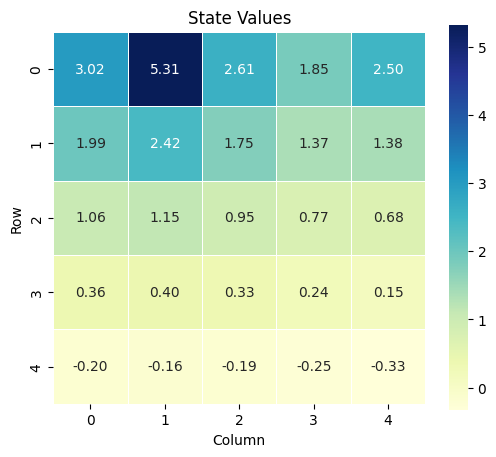

In [22]:
plot_state_value_heat_map(state_value_vector_iter)


Comparing this with the solution in part 1.1.1, we see that the two methods yield the same result.


### 1.2.1: Explicitly Solving the Bellman Optimality Equations

The Bellman optimality equations for the state-value function are given by, $\forall s \in \mathcal{S}$,

\begin{align*}
v_*(s) :=&\, \max_{a \in \mathcal{A}} \mathbb{E}_{\pi_*}[R_{t + 1} + \gamma v_*(S_{t + 1}) | S_t = s, A_t = a] \\
        =&\, \max_a \sum_{s' \in \mathcal{S}, r \in \mathcal{R}} p(s', r | s, a)[r + \gamma v_*(s')].
\end{align*}

Similar to what we did above, we can rewrite this as

$$
v_*(s) = \max_a \left(r(s, a) + \gamma \sum_{s'} P(s', s, a) v_*(s')\right),
$$

where, abusing notation slightly,

$$
r(s, a) := \sum_{s', r} p(s', r | s, a) r,
$$

and

$$
P(s', s, a) := \sum_r p(s', r | s, a).
$$

Defining a vector $\mathbf{v}_*$ and vector-valued function $\mathbf{r} : \mathcal{A} \to \mathbb{R}^{|\mathcal{S}|}$,

$$
\mathbf{v}_* := \begin{bmatrix}
v_*(s_0) \\
v_*(s_1) \\
\vdots \\
v_*(s_{24})
\end{bmatrix}

\quad \text{and} \quad

\mathbf{r}(a) := \begin{bmatrix}
r(s_0, a) \\
r(s_1, a) \\
\vdots \\
r(s_{24}, a) \\
\end{bmatrix},
$$

along with a matrix-valued function $\mathbf{P} : \mathcal{A} \to \mathbb{R}^{|\mathcal{S}| \times |\mathcal{S}|}$,

$$
\mathbf{P}(a) := \begin{bmatrix}
P(s_0, s_0, a)    & P(s_0, s_1, a)    & \cdots & P(s_0, s_{24}, a) \\
P(s_1, s_0, a)    & P(s_1, s_1, a)    & \cdots & P(s_1, s_{24}, a) \\
\vdots            & \vdots            & \ddots & \vdots \\
P(s_{24}, s_0, a) & P(s_{24}, s_1, a) & \cdots & P(s_{24}, s_{24}, a) \\
\end{bmatrix},
$$

we can write the Bellman optimality equations in vector form as

$$
\mathbf{v}_* = \max_a \left(\mathbf{r}(a) + \gamma \mathbf{P}(a)\mathbf{v}_*\right),
$$

where we remember that the $\max_a$ is a row-wise maximum that applies separately to each row in the vector $\mathbf{r}(a) + \gamma \mathbf{P}(a)\mathbf{v}_*$.

Written in this form, solving the Bellman optimality equations just means finding the root of the residual function $\mathbf{R} : \mathbb{R}^{|\mathcal{S}|} \to \mathbb{R}^{|\mathcal{S}|}$:

$$
\mathbf{R}(\mathbf{v}) := \mathbf{v} - \max_a \left(\mathbf{r}(a) + \gamma \mathbf{P}(a)\mathbf{v}\right).
$$

Note that we could have taken this one step further and defined a matrix $\mathbf{R}$ instead of a vector-valued function $\mathbf{r}(a)$, and a rank-3 tensor $\mathbf{P}$ instead of a matrix-valued function $\mathbf{P}(a)$, and used tensor algebra to formulate the approach--in fact, this is the approach used in the implementation below. The two approaches are, effectively, equivelent for our purposes here.


As a first step, we implement convenience functions for generating the transition matrices $\{\mathbf{P}(a) | a \in \mathcal{A}\}$ and the expected rewards vectors $\{\mathbf{r}(a) | a \in \mathcal{A}\}$. As mentioned, these are implemented as a rank-3 tensor, $P_{s s' a}$, and rank-2 tensor (matrix), $R_{s a}$.


In [23]:
def get_transition_matrices(dynamics_table: DynamicsTable) -> npt.NDArray[np.float64]:
    matrices: npt.NDArray[np.float64] = np.zeros((len(STATES), len(STATES), len(Action)), dtype=np.float64)

    for row, state in enumerate(STATES):
        for col, next_state in enumerate(STATES):
            for action_index, action in enumerate(Action):
                records: DynamicsTable = [
                    record for record in dynamics_table
                    if record[0] == state and record[1] == action and record[2] == next_state
                ]
                matrices[row, col, action_index] = sum(record[4] for record in records)

    return matrices


def get_expected_reward_vectors(dynamics_table: DynamicsTable) -> npt.NDArray[np.float64]:      
    vectors: npt.NDArray[np.float64] = np.zeros((len(STATES), len(Action)), dtype=np.float64)

    for state_index, state in enumerate(STATES):
        for action_index, action in enumerate(Action):
            records: DynamicsTable = [
                record for record in dynamics_table if record[0] == state and record[1] == action
            ]
            vectors[state_index, action_index] = sum(record[4] * record[3] for record in records)

    return vectors


Next, we implement the solution as, more-or-less, a wrapper around the nonlinear `scipy.optimize.root` function:


In [24]:
def solve_bellman_optimality_equations(
    initial_state_value_vector: npt.NDArray[np.float64],
    transition_matrices: npt.NDArray[np.float64],
    expected_reward_vectors: npt.NDArray[np.float64],
    discount_factor: float
) -> npt.NDArray[np.float64]:
    def _get_state_value_residual(state_value_vector: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        action_values: npt.NDArray[np.float64] = expected_reward_vectors \
            + discount_factor * np.einsum('ijk,j->ik', transition_matrices, state_value_vector)
        
        return state_value_vector - np.max(action_values, axis=1)

    optimal_state_value_vector_solution: OptimizeResult = root(
        _get_state_value_residual,
        initial_state_value_vector
    )

    if not optimal_state_value_vector_solution.success:
        raise RuntimeError(f"Failed to converge on optimal state value")
    
    return optimal_state_value_vector_solution.x


We compute the optimal state-value vector $\mathbf{v}_*$ using this implementation:


In [25]:
initial_state_value_vector: npt.NDArray[np.float64] = np.zeros(len(STATES), dtype=np.float64)

optimal_state_value_vector: npt.NDArray[np.float64] = solve_bellman_optimality_equations(
    initial_state_value_vector,
    get_transition_matrices(DYNAMICS_TABLE),
    get_expected_reward_vectors(DYNAMICS_TABLE),
    DISCOUNT_FACTOR
)


With $v_*(s)$ in-hand, we define the optimal policy $\pi_*(s)$, which, as the notation suggests, is deterministic, to be

$$
\pi_*(s) := \argmax_a q_*(s, a),
$$

where $q_*(s, a)$ is the optimal action-value function, which can be expressed as

\begin{align*}
q_*(s, a) :=&\, \mathbb{E}[R_{t + 1} + \gamma G_{t + 1} | S_t = s, A_t = a] \\
           =&\, \mathbb{E}[R_{t + 1} | S_t = s, A_t = a]
                + \gamma \mathbb{E}[G_{t + 1} | S_t = s, A_t = a] \\
           =&\, \sum_r r \sum_{s'} p(s', r | s, a)
                + \gamma \sum_{s'} \mathbb{E}[G_{t + 1} | S_t = s, A_t = a, S_{t + 1} = s'] \sum_r p(s', r | s, a) \\
           =&\, \sum_r r \sum_{s'} p(s', r | s, a)
                + \gamma \sum_{s'} \mathbb{E}[G_{t + 1} | S_{t + 1} = s'] \sum_r p(s', r | s, a) \\
           =&\, \sum_r r \sum_{s'} p(s', r | s, a)
                + \gamma \sum_{s'} v_*(s') \sum_r p(s', r | s, a) \\
           =&\, \sum_{s', r} p(s', r | s, a) [r + \gamma v_*(s')].
\end{align*}

Putting these together yields

$$
\pi_*(s) = \argmax_a \sum_{s', r} p(s', r | s, a) [r + \gamma v_*(s')],
$$

which we can rewrite using $r(s, a)$ and $P(s', s, a)$ from above as

$$
\pi_*(s) = \argmax_a \left(r(s, a) + \gamma \sum_{s'} P(s', s, a) v_*(s')\right),
$$

or, in vector notation,

$$
\boldsymbol{\pi}_* := \argmax_a \left(\mathbf{r}(a) + \gamma \mathbf{P}(a)\mathbf{v}_*\right),
$$

where

$$
\boldsymbol{\pi}_* := \begin{bmatrix}
\pi_*(s_0) \\
\pi_*(s_1) \\
\vdots \\
\pi_*(s_{24})
\end{bmatrix},
$$

 $\mathbf{r}(a)$ is the expected reward vector function, $\mathbf{P}(a)$ is the transition matrix function, and $\mathbf{v}_*$ is the optimal state value vector, all as defined above. Also as above, the $\argmax_a$ is understood to apply row-wise.

We can use this formulation to implement the calculation of the optimal policy as follows:



In [26]:
def get_greedy_policy(
    state_value_vector: npt.NDArray[np.float64],
    transition_matrices: npt.NDArray[np.float64],
    expected_reward_vectors: npt.NDArray[np.float64],
    discount_factor: float
) -> Policy:
    action_values: npt.NDArray[np.float64] = expected_reward_vectors \
        + discount_factor * np.einsum('ijk,j->ik', transition_matrices, state_value_vector)
    
    greedy_action_indices: npt.NDArray[np.int64] = np.argmax(action_values, axis=1)
    greedy_actions: list[Action] = [get_action(action_index) for action_index in greedy_action_indices]

    probability_distribution_map: dict[State, dict[Action, float]] = {
        STATES[state_index]: {action: 1.0 if action == greedy_action else 0.0 for action in Action}
        for state_index, greedy_action in enumerate(greedy_actions)
    }

    return Policy(probability_distribution_map, np.random.default_rng())


We can then calculate the optimal policy given our optimal state value vector:


In [27]:
optimal_policy: dict[State, Action] = get_greedy_policy(
    optimal_state_value_vector,
    get_transition_matrices(DYNAMICS_TABLE),
    get_expected_reward_vectors(DYNAMICS_TABLE),
    DISCOUNT_FACTOR
)


Finally, we can visualize the results:


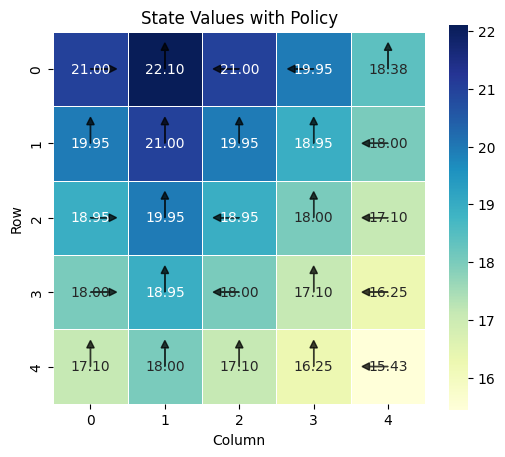

In [28]:
plot_state_value_heat_map_with_policy(
    optimal_state_value_vector,
    optimal_policy
)

As can be seen, $\pi_*$ always picks the action that results in the greatest one-step-ahead state-value. This is expected of a greedy policy.

One thing to note is the, at first glance, surprising choice of "up" from the blue and green squares. In these cases, all actions yield the same result, so the choice of action is irrelevant.


### 1.2.2: Policy Iteration

As an alternative to directly solving the Bellman equations in order to perform policy evaluation (i.e., computing the state value function for a given policy), iterative methods can be used which allow solutions to be found even for problems of massive scale.

One such iterative method is known as _policy iteration_, which involves two steps: 1) policy evaluation using iterative policy evaluation; and 2) policy improvement. In the following, we implement policy iteration and compare the results to those obtained by direct solution of the Bellman equations.


First, we define two convenience functions: 1) for computing the policy-aware transition matrix; and 2) for computing the policy-aware expected reward vector. These will simplify the later implementations.

Note that, although the naming leaves a lot to be desired, by "policy-aware", we mean that the update rule assumes that the policy is deterministic, i.e., $\pi(a | s) = \pi(s)$, yielding

\begin{align*}
v_{k + 1}(s) =&\, \sum_{s', r} p(s', r | s, \pi(s)) [r + \gamma v_k(s')] \\
             =&\, r_{\pi}(s) + \gamma \sum_{s'}P_{\pi}(s, s') v_k(s'),
\end{align*}

where, similar to above, we define functions

$$
r_{\pi}(s) := \sum_{s', r} p(s', r | s, \pi(s)) r,
$$

and

$$
P_{\pi}(s, s') := \sum_{r} p(s', r | s, \pi(s)).
$$

We introduce vectors $\mathbf{v}_{\pi}$ and $\mathbf{r}_{\pi}$, along with a matrix $\mathbf{P}_{\pi}$ following the same pattern as that already established, and iterate on the value function according to the update rule

$$
\mathbf{v}_{k + 1} = \mathbf{r}_{\pi} + \mathbf{P}_{\pi} \mathbf{v}_k.
$$


In [29]:
def get_policy_aware_transition_matrix(
    dynamics_table: DynamicsTable,
    policy: Policy
) -> npt.NDArray[np.float64]:
    matrix: npt.NDArray[np.float64] = np.zeros((len(STATES), len(STATES)), dtype=np.float64)

    for row, state in enumerate(STATES):
        for col, next_state in enumerate(STATES):
            records: DynamicsTable = [
                record for record in dynamics_table
                if record[0] == state and record[1] == policy.get_action(state) and record[2] == next_state
            ]
            matrix[row, col] = sum(record[4] for record in records)

    return matrix


def get_policy_aware_expected_reward_vector(
    dynamics_table: DynamicsTable,
    policy: Policy
) -> npt.NDArray[np.float64]:
    vector: npt.NDArray[np.float64] = np.zeros(len(STATES), dtype=np.float64)

    for index, state in enumerate(STATES):
        records: DynamicsTable = [
            record for record in dynamics_table if record[0] == state and record[1] == policy.get_action(state)
        ]
        vector[index] = sum(record[4] * record[3] for record in records)

    return vector
    

The following function implements the policy iteration algorithm, using iterative policy evaluation to do the prediction step. We rely heavily on previous implementations of the steps, including the iterative policy evaluation algorithm. We stop iterating when the policy is no longer changing, at which point we have found the optimal policy.


In [ ]:
def do_policy_iteration(
    initial_state_value_vector: npt.NDArray[np.float64],
    initial_policy: Policy,
    dynamics_table: DynamicsTable,
    discount_factor: float,
    convergence_threshold: float
) -> tuple[npt.NDArray[np.float64], Policy]:
    state_value_vector: npt.NDArray[np.float64] = initial_state_value_vector.copy()
    policy: Policy = deepcopy(initial_policy)
    policy_temp: Policy = deepcopy(policy)

    iteration_counter: int = 0
    while True:
        if iteration_counter > 10000:
            raise RuntimeError(f"Failed to find optimal policy after 10,000 iterations")
        
        state_value_vector = do_iterative_policy_evaluation(
            state_value_vector,
            get_policy_aware_transition_matrix(dynamics_table, policy),
            get_policy_aware_expected_reward_vector(dynamics_table, policy),
            discount_factor,
            convergence_threshold
        )

        policy = get_greedy_policy(
            state_value_vector,
            get_transition_matrices(dynamics_table),
            get_expected_reward_vectors(dynamics_table),
            discount_factor
        )

        if policy == policy_temp:
            break

        policy_temp = deepcopy(policy)

    return state_value_vector, policy


Using the above, we compute the optimal state value function and optimal policy:


In [31]:
initial_state_value_vector: npt.NDArray[np.float64] = np.zeros(len(STATES), dtype=np.float64)
initial_probability_distribution_map: dict[State, dict[Action, float]] = {
    state: {action: 1.0 if action == Action.UP else 0.0 for action in Action} for state in STATES
}
initial_policy: Policy = Policy(initial_probability_distribution_map, np.random.default_rng())

optimal_state_value_vector_iter, optimal_policy_iter = do_policy_iteration(
    initial_state_value_vector,
    initial_policy,
    DYNAMICS_TABLE,
    DISCOUNT_FACTOR,
    CONVERGENCE_THRESHOLD
)


Finally, we visualize the state value function and policy as usual:


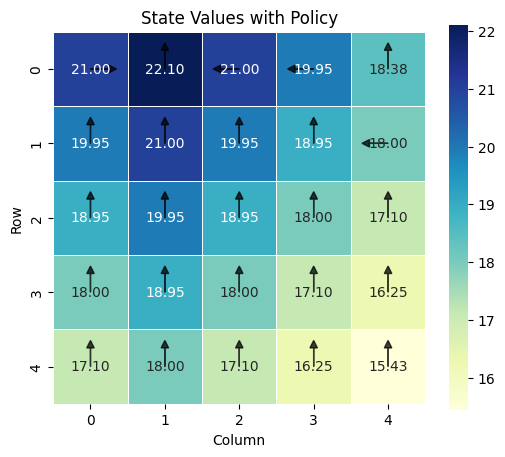

In [32]:
plot_state_value_heat_map_with_policy(
    optimal_state_value_vector_iter,
    optimal_policy_iter
)


While there are some minor deviations in the policy from the exact solutions above, the end result is essentially identical. The differences appear mainly to be due to alternate choices in equivalent one-step-ahead state values for the policy. This may be due to minute differences in the state values computed during the iterative process.


### 1.2.3: Value Iteration

Value iteration is essentially a short-circuited version of policy iteration that uses the following update rule:

$$
v_{k + 1}(s) = \max_a \sum_{s', r} p(s', r | s, a) [r + \gamma v_k{s'}].
$$

The following uses the now established matrix/vector form of this update rule to converge on an optimal policy:


In [33]:
def do_value_iteration(
    initial_state_value_vector: npt.NDArray[np.float64],
    dynamics_table: DynamicsTable,
    discount_factor: float,
    convergence_threshold: float
) -> tuple[npt.NDArray[np.float64], dict[State, Action]]:
    transition_matrices: npt.NDArray[np.float64] = get_transition_matrices(dynamics_table)
    expected_reward_vectors: npt.NDArray[np.float64] = get_expected_reward_vectors(dynamics_table)

    def _get_max_action_value_vector(state_value_vector: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        action_values: npt.NDArray[np.float64] = expected_reward_vectors \
            + discount_factor * np.einsum('ijk,j->ik', transition_matrices, state_value_vector)
        
        return np.max(action_values, axis=1)
    
    state_value_vector_iter: npt.NDArray[np.float64] = initial_state_value_vector.copy()
    state_value_vector_temp: npt.NDArray[np.float64] = state_value_vector_iter.copy()

    while True:
        state_value_vector_iter = _get_max_action_value_vector(state_value_vector_iter)
        if np.max(np.abs(state_value_vector_iter - state_value_vector_temp)) < convergence_threshold:
            break
        state_value_vector_temp = state_value_vector_iter.copy()

    policy: dict[State, Action] = get_greedy_policy(
        state_value_vector_iter,
        transition_matrices,
        expected_reward_vectors,
        discount_factor
    )

    return state_value_vector_iter, policy


Using this implementation, we generate an optimal policy to the gridworld problem as follows:


In [34]:
initial_state_value_vector: npt.NDArray[np.float64] = np.zeros(len(STATES), dtype=np.float64)

optimal_state_value_vector_value_iter, optimal_policy_value_iter = do_value_iteration(
    initial_state_value_vector,
    DYNAMICS_TABLE,
    DISCOUNT_FACTOR,
    CONVERGENCE_THRESHOLD
)


We visualize the solution as per usual:


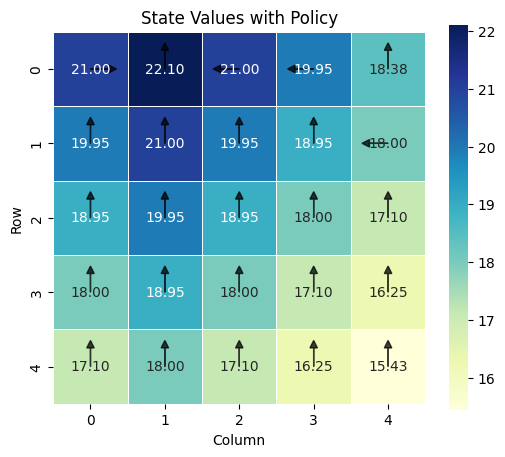

In [35]:
plot_state_value_heat_map_with_policy(
    optimal_state_value_vector_value_iter,
    optimal_policy_value_iter
)


Comparing with the policy iteration solution, the results look identical.


## Part 2: With Terminal States

In the modified gridworld, the dynamics function $p(s', r | s, a)$ can be defined via the following table:

| $s$             | $a$            | $s'$            | $r$    | $p$   |
|:---------------:|:--------------:|:---------------:|:------:|:-----:|
| $\text{blue}$   | $\text{up}$    | $\text{red}$    | $5$    | $1$   |
| $\text{blue}$   | $\text{down}$  | $\text{red}$    | $5$    | $1$   |
| $\text{blue}$   | $\text{left}$  | $\text{red}$    | $5$    | $1$   |
| $\text{blue}$   | $\text{right}$ | $\text{red}$    | $5$    | $1$   |
| $\text{green}$  | $\text{up}$    | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{down}$  | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{left}$  | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{right}$ | $\text{red}$    | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{up}$    | $\text{yellow}$ | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{down}$  | $\text{yellow}$ | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{left}$  | $\text{yellow}$ | $2.5$  | $0.5$ |
| $\text{green}$  | $\text{right}$ | $\text{yellow}$ | $2.5$  | $0.5$ |
| $(0, j)$        | $\text{up}$    | $(0, j)$        | $-0.5$ | $1$   |
| $(4, j)$        | $\text{down}$  | $(4, j)$        | $-0.5$ | $1$   |
| $(i, 0)$        | $\text{left}$  | $(i, 0)$        | $-0.5$ | $1$   |
| $(i, 4)$        | $\text{right}$ | $(i, 4)$        | $-0.5$ | $1$   |
| $(i, j)$        | $\text{up}$    | $(i - 1, j)$    | $-0.2$ | $1$   |
| $(i, j)$        | $\text{down}$  | $(i + 1, j)$    | $-0.2$ | $1$   |
| $(i, j)$        | $\text{left}$  | $(i, j - 1)$    | $-0.2$ | $1$   |
| $(i, j)$        | $\text{right}$ | $(i, j + 1)$    | $-0.2$ | $1$   |


We can take advantage of the previous implementation to define an updated version of the dynamics table for use in the below:


In [36]:
DYNAMICS_TABLE_WITH_TERMINAL_STATES: DynamicsTable = get_dynamics_table(-0.2)


We also create a list of the terminal states for future use:


In [37]:
TERMINAL_STATES: list[State] = [
    get_state(2, 0),
    get_state(2, 4),
    get_state(4, 0)
]


Next, we define some convenience functions for computing the reward and next state from the dynamics table. These will be useful in the upcoming implementations.


In [38]:
def get_dynamics_table_record_by_state_action_pair(
    dynamics_table: DynamicsTable,
    state: State,
    action: Action
) -> tuple[State, Action, State, float, float]:
    records: list[tuple[State, Action, State, float, float]] = list(filter(
        lambda record: record[0] == state and record[1] == action,
        dynamics_table
    ))
    if len(records) == 0:
        raise RuntimeError(f"No dynamics table record found for state/action pair ({state}, {action})")

    record_index: int = 0
    if len(records) > 1:
        # TODO: Make this use the probability distribution
        record_index = np.random.choice(len(records))
    
    return records[record_index]


def get_next_state(dynamics_table: DynamicsTable, state: State, action: Action) -> State:
    record: tuple[State, Action, State, float, float] = get_dynamics_table_record_by_state_action_pair(
        dynamics_table,
        state,
        action
    )

    return record[2]


def get_reward(dynamics_table: DynamicsTable, state: State, action: Action) -> float:
    record: tuple[State, Action, State, float, float] = get_dynamics_table_record_by_state_action_pair(
        dynamics_table,
        state,
        action
    )

    return record[3]


Next, we define a container that will hold an _episode_, which, here, we require to hold the trajectory, i.e., the sequence $S_0$, $A_0$, $R_1$, $S_1$, $A_1$, $\ldots$, $R_T$, $S_T$, where $T$ is the terminal time step, for the episode.

For convenience, we also include an occurrence map, which holds a list of time steps each state-action pair occurs during an episode.


In [39]:
Trajectory: TypeAlias = list[tuple[int, float, State, Action]]
Occurrences: TypeAlias = dict[tuple[State, Action], list[int]]

@dataclass
class Episode:
    trajectory: Trajectory | None = None
    occurrences: Occurrences | None = None

    def __post_init__(self) -> None:
        self.trajectory: Trajectory = list()
        self.occurrences: Occurrences = {
            (state, action): [] for state in STATES for action in Action
        }


The following function is used from here on to generate episodes starting from an initial state-action pair according to a policy and the gridworld dynamics, specified in the dynamics table above.

Aside from reaching a terminal state, we're forced to include an alternate episode termination criterion in the form of a max step number. This is to prevent infinite episodes occuring due to cycles that can form during the GPI loop.


In [40]:
def generate_episode(
    initial_state: State,
    initial_action: Action,
    policy: Policy,
    dynamics_table: DynamicsTable,
    max_steps_per_episode: int
) -> Episode:
    episode: Episode = Episode()
    reward: float = 0.0     # This is a departure from the theory, but is harmless
    state: State = initial_state
    action: Action = initial_action
    time_step: int = 0
    while True:
        episode.trajectory.append((time_step, reward, state, action))
        episode.occurrences[(state, action)].append(time_step)
        if state in TERMINAL_STATES:
            break
        reward: float = get_reward(dynamics_table, state, action)
        state: State = get_next_state(dynamics_table, state, action)
        action: Action = policy.get_action(state)
        time_step += 1
        if time_step >= max_steps_per_episode:
            break

    return episode


Finally, we define a function for computing the state value function from a policy and the action value function according to

$$
v_{\pi}(s) = \sum_a \pi(a | s) q_{\pi}(s, a).
$$


In [41]:
def get_approximate_state_value_vector(
    policy: Policy,
    action_values: npt.NDArray[np.float64]
) -> npt.NDArray[np.float64]:
    state_value_vector: npt.NDArray = np.zeros(len(STATES), dtype=np.float64)
    for state in STATES:
        state_index: int = get_state_index(state)
        for action in Action:
            action_index: int = get_action_index(action)
            probability: float = policy.get_probability(state, action)
            action_value: float = action_values[state_index, action_index]
            state_value_vector[state_index] += probability * action_value

    return state_value_vector


### 2.1.1: Monte Carlo Method With Exploring Starts

One important consideration when using sample averages to approximate expected values is that a large number of samples is required in order to obtain an accurate estimation. If $\pi$ is deterministic, it is possible, or maybe even definite, that unless we are careful we will not visit all state-action pairs, and therefore will not be able to accurately estimate the action value function.

One way to ensure that this does not happen is to enforce the assumption of exploring starts, which asserts that episodes start in a state-action pair, and that every pair as a nonzero probability of being selected as the start of an episode. In this way, we can be guaranteed that, in the limit of infinite episodes, every state-action pair will be visited infinitely many times, hence our estimate will converge to the expected value.

This is the idea behind the Monte Carlo with Exploring Starts method, implemented below:


In [42]:
def do_monte_carlo_with_exploring_starts(
    initial_action_values: npt.NDArray[np.float64],
    initial_policy: Policy,
    discount_factor: float,
    num_episodes: int,
    max_steps_per_episode: int, 
    rng: np.random.Generator
) -> tuple[npt.NDArray[np.float64], Policy]:
    action_values: npt.NDArray[np.float64] = initial_action_values.copy()
    policy: Policy = deepcopy(initial_policy)
    returns: dict[tuple[State, Action], list[float]] = {
        (state, action): [] for state in STATES for action in Action
    }
    for _ in range(num_episodes):
        # This satisfies the exploring starts assumption: Episodes start in a state-action pair,
        # and every pair has a nonzero probability of being selected as the start of an episode
        initial_state: State = rng.choice(STATES)
        initial_action: Action = rng.choice(list(Action))

        episode: Episode = generate_episode(
            initial_state,
            initial_action,
            policy,
            DYNAMICS_TABLE_WITH_TERMINAL_STATES,
            max_steps_per_episode
        )
        
        current_return: float = 0.
        for time_step, _, state, action in reversed(episode.trajectory[:-1]):
            # Update the return
            reward: float = episode.trajectory[time_step + 1][1]
            current_return = discount_factor * current_return + reward

            # Ensure this is the first visit to this (state, action) pair
            if any(t < time_step for t in episode.occurrences[(state, action)]):
                continue

            # Add the return for this episode to the list of returns for this (state, action) pair 
            returns[(state, action)].append(current_return)

            # Update the action value for this (state, action) pair
            action_values[get_state_index(state), get_action_index(action)] = np.mean(returns[(state, action)])

            # Greedily update the policy based on the updated action values
            best_action: Action = get_best_action(state, action_values, rng)
            policy_probability_distribution: dict[Action, float] = {
                action: 1.0 if action is best_action else 0.0 for action in Action
            }
            policy.update(state, policy_probability_distribution)

    return get_approximate_state_value_vector(policy, action_values), policy


Using this implementation, we can use the MC with ES method to find an optimal policy for the updated gridworld problem:


In [43]:
initial_action_values: npt.NDArray[np.float64] = np.zeros((len(STATES), len(Action)), dtype=np.float64)

initial_policy_seed: int = 1337
initial_policy_rng: np.random.Generator = np.random.default_rng(initial_policy_seed)
initial_probability_distribution_map: dict[State, dict[Action, float]] = {
    state: {action: 0.25 for action in Action} for state in STATES
}
initial_policy: Policy = Policy(initial_probability_distribution_map, initial_policy_rng)

max_steps_per_episode: int = 100
num_episodes: int = 10000

monte_carlo_seed: int = 42
monte_carlo_rng: np.random.Generator = np.random.default_rng(monte_carlo_seed)

state_value_vector_mc_exploring_starts, policy_mc_exploring_starts = do_monte_carlo_with_exploring_starts(
    initial_action_values,
    initial_policy,
    DISCOUNT_FACTOR,
    num_episodes,
    max_steps_per_episode,
    monte_carlo_rng
)
    

With an optimal solution, we can visualize it in the usual way:


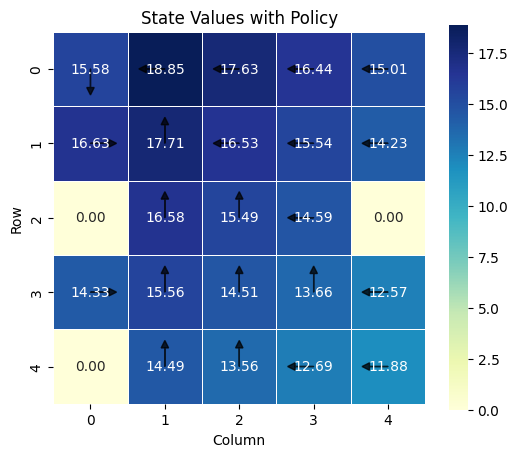

In [44]:
plot_state_value_heat_map_with_policy(
    state_value_vector_mc_exploring_starts,
    policy_mc_exploring_starts,
    ignored_states=TERMINAL_STATES
)


The results here seem reasonable, with the policy directing the agent toward the blue state. This is sensible since, as with the gridworld from part 1, that state offers the largest reward on the grid, so we would expect to seek it out.


### 2.1.2: Monte Carlo Method With Epsilon-Soft Policy

The assumption of exploring starts is, in many cases, impractical or impossible to satisfy. As an alternative means of ensuring all state-action pairs are explored, we can employ a so-called soft policy, where all state-action pairs have a nonzero probability of being selected.

In [45]:
def do_monte_carlo_with_epsilon_soft_policy(
    initial_state: State,
    initial_action: Action,
    initial_action_values: npt.NDArray[np.float64],
    initial_policy: Policy,
    discount_factor: float,
    epsilon: float,
    num_episodes: int,
    max_steps_per_episode: int, 
    rng: np.random.Generator
) -> tuple[npt.NDArray[np.float64], Policy]:
    action_values: npt.NDArray[np.float64] = initial_action_values.copy()
    policy: Policy = deepcopy(initial_policy)
    returns: dict[tuple[State, Action], list[float]] = {
        (state, action): [] for state in STATES for action in Action
    }
    
    for _ in range(num_episodes):
        episode: Episode = generate_episode(
            initial_state,
            initial_action,
            policy,
            DYNAMICS_TABLE_WITH_TERMINAL_STATES,
            max_steps_per_episode
        )
        
        current_return: float = 0.
        for time_step, _, state, action in reversed(episode.trajectory[:-1]):
            # Update the return
            reward: float = episode.trajectory[time_step + 1][1]
            current_return = discount_factor * current_return + reward

            # Ensure this is the first visit to this (state, action) pair
            if any(t < time_step for t in episode.occurrences[(state, action)]):
                continue

            # Add the return for this episode to the list of returns for this (state, action) pair 
            returns[(state, action)].append(current_return)

            # Update the action value for this (state, action) pair
            action_values[get_state_index(state), get_action_index(action)] = np.mean(returns[(state, action)])

            # Update the epsilon-soft policy based on the updated action values
            best_action: Action = get_best_action(state, action_values, rng)
            policy_probability_distribution: dict[Action, float] = {
                action: 1.0 - epsilon + (epsilon / len(Action)) if action is best_action else epsilon / len(Action)
                for action in Action
            }
            policy.update(state, policy_probability_distribution)

    return get_approximate_state_value_vector(policy, action_values), policy


In [46]:
initial_state: State = State(4, 4)
initial_action: Action = Action.UP

initial_action_values: npt.NDArray[np.float64] = np.zeros((len(STATES), len(Action)), dtype=np.float64)

initial_policy_seed: int = 1337
initial_policy_rng: np.random.Generator = np.random.default_rng(initial_policy_seed)
initial_probability_distribution_map: dict[State, dict[Action, float]] = {
    state: {action: 0.25 for action in Action} for state in STATES
}
initial_policy: Policy = Policy(initial_probability_distribution_map, initial_policy_rng)

epsilon: float = 0.3

max_steps_per_episode: int = 100
num_episodes: int = 20000

monte_carlo_seed: int = 42
monte_carlo_rng: np.random.Generator = np.random.default_rng(monte_carlo_seed)

state_value_vector_mc_epsilon_soft, policy_mc_epsilon_soft = do_monte_carlo_with_epsilon_soft_policy(
    initial_state,
    initial_action,
    initial_action_values,
    initial_policy,
    DISCOUNT_FACTOR,
    epsilon,
    num_episodes,
    max_steps_per_episode,
    monte_carlo_rng
)
    

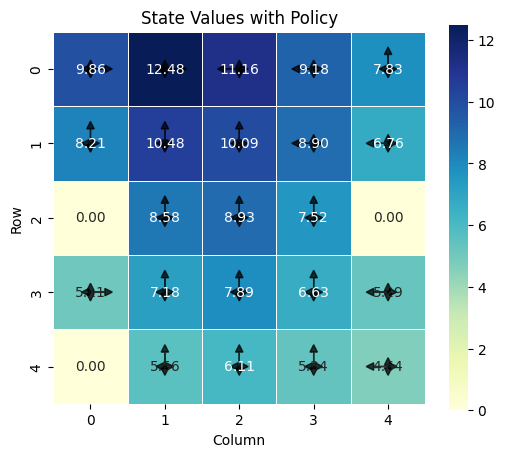

In [47]:
plot_state_value_heat_map_with_policy(
    state_value_vector_mc_epsilon_soft,
    policy_mc_epsilon_soft,
    ignored_states=TERMINAL_STATES
)


### 2.1: Off-Policy Monte Carlo

In [48]:
def do_off_policy_monte_carlo(
    initial_state: State,
    initial_action: Action,
    initial_action_values: npt.NDArray[np.float64],
    initial_policy: Policy,
    behaviour_policy: Policy,
    discount_factor: float,
    num_episodes: int,
    max_steps_per_episode: int, 
    rng: np.random.Generator
) -> tuple[npt.NDArray[np.float64], Policy]:
    action_values: npt.NDArray[np.float64] = initial_action_values.copy()
    policy: Policy = deepcopy(initial_policy)
    cumulative_weights: dict[tuple[State, Action], float] = {
        (state, action): 0.0 for state in STATES for action in Action
    }
    
    for _ in range(num_episodes):
        episode: Episode = generate_episode(
            initial_state,
            initial_action,
            behaviour_policy,
            DYNAMICS_TABLE_WITH_TERMINAL_STATES,
            max_steps_per_episode
        )
        
        current_return: float = 0.0
        current_weight: float = 1.0
        for time_step, _, state, action in reversed(episode.trajectory[:-1]):
            # Update the return
            reward: float = episode.trajectory[time_step + 1][1]
            current_return = discount_factor * current_return + reward

            # Update the cumulative weight for this (state, action) pair
            cumulative_weights[(state, action)] += current_weight

            # Update the action value estimate for this (state, action) pair
            state_index: int = get_state_index(state)
            action_index: int = get_action_index(action)
            step_size: float = current_weight / cumulative_weights[(state, action)]
            current_action_value: float = action_values[state_index, action_index]
            action_values[state_index, action_index] = current_action_value \
                + step_size * (current_return - current_action_value)
            
            # Update the policy for this state
            best_action: Action = get_best_action(state, action_values, rng)
            policy_probability_distribution: dict[Action, float] = {
                action: 1.0 if action is best_action else 0.0 for action in Action
            }
            policy.update(state, policy_probability_distribution)

            if action != policy.get_action(state):
                break

            # Update the weight
            current_weight *= 1.0 / behaviour_policy.get_probability(state, action)

    return get_approximate_state_value_vector(policy, action_values), policy


Using the above, we attempt to solve the problem using the off-policy Monte Carlo approach:


In [49]:
initial_state: State = State(4, 4)
initial_action: Action = Action.UP

initial_action_values: npt.NDArray[np.float64] = np.zeros((len(STATES), len(Action)), dtype=np.float64)

initial_policy_seed: int = 1337
initial_policy_rng: np.random.Generator = np.random.default_rng(initial_policy_seed)
initial_probability_distribution_map: dict[State, dict[Action, float]] = {
    state: {action: 0.25 for action in Action} for state in STATES
}
initial_policy: Policy = Policy(initial_probability_distribution_map, initial_policy_rng)

behaviour_policy_seed: int = 314159
behaviour_policy_rng: np.random.Generator = np.random.default_rng(behaviour_policy_seed)
behaviour_probability_distribution_map: dict[State, dict[Action, float]] = {
    state: {action: 0.25 for action in Action} for state in STATES
}
behaviour_policy: Policy = Policy(behaviour_probability_distribution_map, behaviour_policy_rng)

max_steps_per_episode: int = 100
num_episodes: int = 500000

monte_carlo_seed: int = 42
monte_carlo_rng: np.random.Generator = np.random.default_rng(monte_carlo_seed)

state_value_vector_mc_off_policy, policy_mc_off_policy = do_off_policy_monte_carlo(
    initial_state,
    initial_action,
    initial_action_values,
    initial_policy,
    behaviour_policy,
    DISCOUNT_FACTOR,
    num_episodes,
    max_steps_per_episode,
    monte_carlo_rng
)
    

We visualize the results in the usual way:


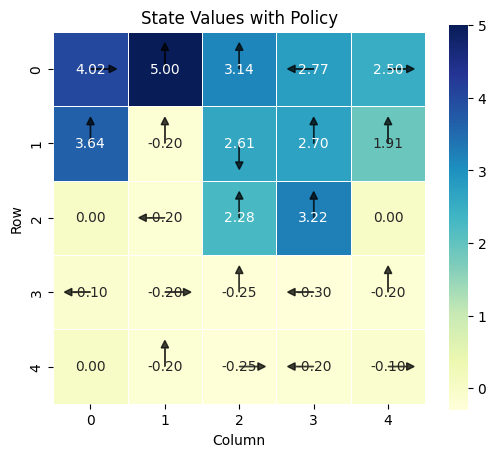

In [50]:
plot_state_value_heat_map_with_policy(
    state_value_vector_mc_off_policy,
    policy_mc_off_policy,
    ignored_states=TERMINAL_STATES
)


As can be seen in the above, even after many, many iterations, the off-policy Monte Carlo algorithm implemented above fails to converge on the expected solution. This may be due to an error in implementation, or it may just be due to the known issue where this method can be slow to converge. Given the very large number of iterations completed here, the latter feels unlikely; it feels far more probable that there is an implementation error that, unfortunately, could not be found in time.
